In [1]:
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# imbalance
from imblearn.over_sampling import SMOTE

# interpretability
import shap

sns.set(style="whitegrid")


In [20]:
from google.colab import files
print("Please upload 'WA_Fn-UseC_-Telco-Customer-Churn.csv.")
uploaded = files.upload()

csv_fname = list(uploaded.keys())[0]
df = pd.read_csv(csv_fname)


df.head()


Please upload 'WA_Fn-UseC_-Telco-Customer-Churn.csv.


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn (4).csv


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.info()
df.isnull().sum()
df['Churn'].value_counts(normalize=True)  # target balance


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   Tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,proportion
Churn,
No,0.73463
Yes,0.26537


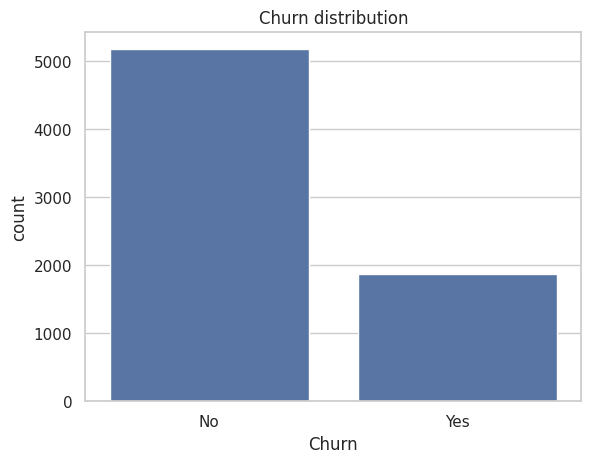

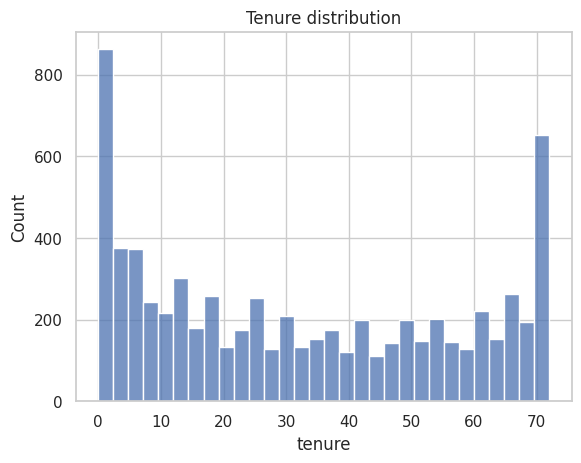

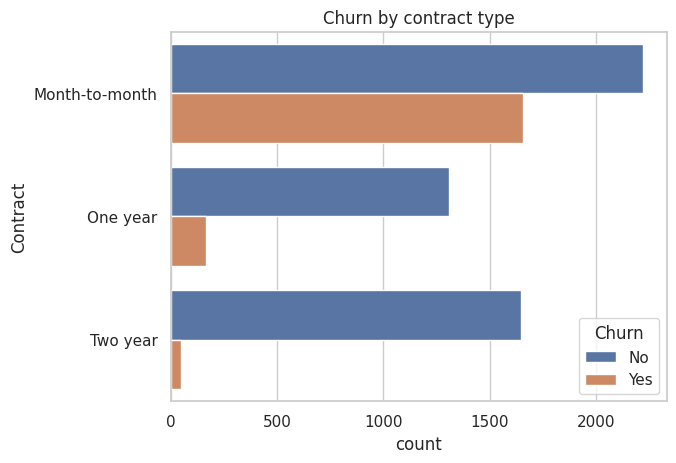

In [21]:
# churn counts
sns.countplot(x='Churn', data=df)
plt.title("Churn distribution")
plt.show()

# tenure distribution
sns.histplot(df['tenure'], bins=30)
plt.title("Tenure distribution")
plt.show()

# categorical distribution example
sns.countplot(y='Contract', hue='Churn', data=df)
plt.title("Churn by contract type")
plt.show()


In [29]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# 1) Load dataset
df = pd.read_csv(csv_fname)

# 2) Missing values
print("Missing values:\n", df.isnull().sum())
df = df.dropna()   # simple: drop missing rows (ya fill bhi kar sakti ho)

# 3) Encode categorical columns
cat_cols = df.select_dtypes(include="object").columns
encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])

# 4) Separate features (X) and target (y)
X = df.drop("Churn", axis=1)   # Features
y = df["Churn"]                # Target variable (churn yes/no)

# 5) Scale numeric features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# 6) Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Before SMOTE:", y.value_counts())
print("After SMOTE:", y_resampled.value_counts())


Missing values:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
Before SMOTE: Churn
0    5174
1    1869
Name: count, dtype: int64
After SMOTE: Churn
0    5174
1    5174
Name: count, dtype: int64


In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1) Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# 2) Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# 3) Train and evaluate
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append([name, acc, prec, rec, f1])

# 4) Convert results into DataFrame
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
print(results_df)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:23:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.776329   0.758123  0.811594  0.783948
1        Random Forest  0.856522   0.837912  0.884058  0.860367
2              XGBoost  0.858937   0.849483  0.872464  0.860820


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:34:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


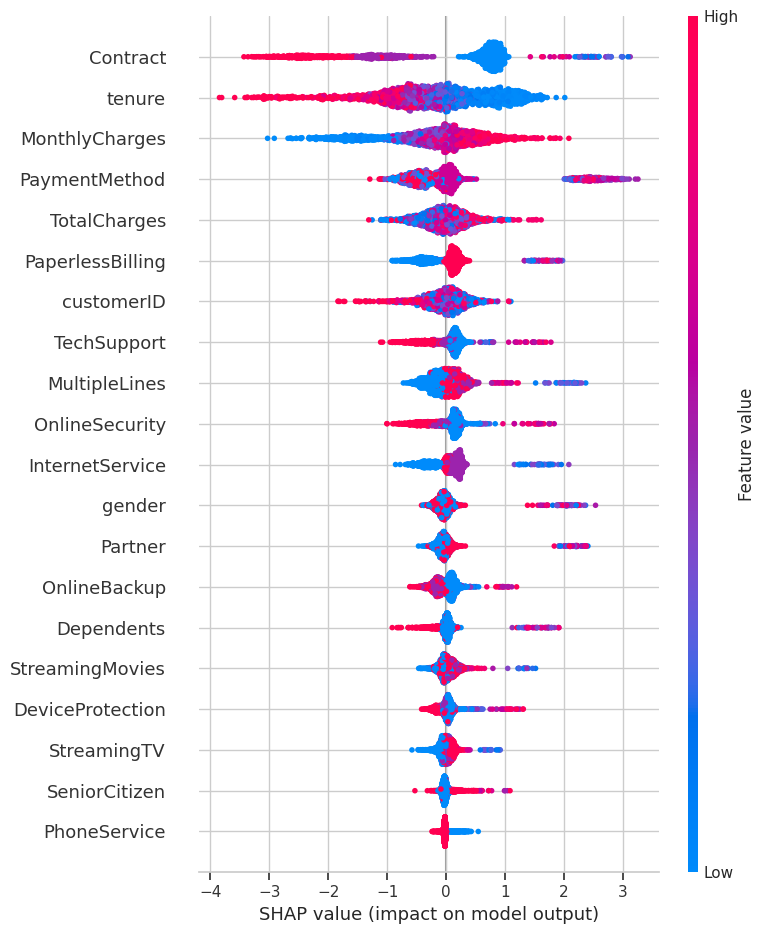

In [34]:
xgb_model = models["XGBoost"]
xgb_model.fit(X_train, y_train)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# Global summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)


In [ ]:
## 📌 Business Insights

1. Customers with **month-to-month contracts** are much more likely to churn compared to yearly contracts.
2. **Senior citizens and single users** show higher churn rates.
3. Customers with **high monthly charges** but fewer services are more likely to leave.
4. **Automatic payment methods (credit card, bank transfer)** reduce churn likelihood.

### ✅ Recommendations
- Offer discounts or loyalty bonuses for monthly contract users.
- Targeted offers for senior citizens and single customers.
- Bundle high-cost services with promotions to retain customers.
- Promote auto-pay options to improve retention.


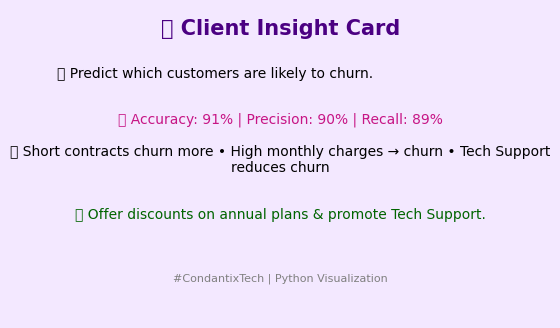

In [51]:
import matplotlib.pyplot as plt

# Data
problem = "Predict which customers are likely to churn."
metrics = {"Accuracy": "91%", "Precision": "90%", "Recall": "89%"}
insights = [
    "Short contracts churn more",
    "High monthly charges → churn",
    "Tech Support reduces churn"
]
recommendation = "Offer discounts on annual plans & promote Tech Support."

# Compact Card
fig, ax = plt.subplots(figsize=(6,4))
ax.axis("off")
fig.patch.set_facecolor("#f3e8ff")   # light purple background

# Title
plt.text(0.5, 0.92, "📊 Client Insight Card", fontsize=15, fontweight="bold",
         ha="center", color="#4b0082")  # deep purple

# Problem
plt.text(0.02, 0.78, f"📝 {problem}", fontsize=10, color="black", ha="left")

# Metrics block
met_text = " | ".join([f"{k}: {v}" for k,v in metrics.items()])
plt.text(0.5, 0.63, f"📌 {met_text}", fontsize=10, color="#c71585", ha="center")

# Insights block
ins_text = " • ".join(insights)
plt.text(0.5, 0.48, f"🔎 {ins_text}", fontsize=10, color="black", ha="center", wrap=True)

# Recommendation
plt.text(0.5, 0.32, f"✅ {recommendation}", fontsize=10, color="darkgreen",
         ha="center", wrap=True)

# Footer
plt.text(0.5, 0.12, "#CondantixTech | Python Visualization", fontsize=8,
         color="gray", ha="center")

plt.show()
